# Machine Learning Analysis Report

I began by importing the cleaned dataset called "traffic_clean" and viewing its first 5 rows. 

Note:  Relevant portions from this report are interspersed throughout the code below for context.

## Final Preparations of the Dataset

I then filtered the dataset to include information pertaining only to drivers, rather than passengers or pedestrians, by setting the variable Person Type ('PER_TYP') equal to 1, Driver of a Motor Vehicle In-Transport. I then dropped a number of variables that, upon further examination, proved to contain duplicative information, such as 'WEATHER1', 'WEATHER2', 'CF1', 'CF2' and 'CF3' (containing causation information included in other variables) in an effort to simplify the model and reduce the chances of overfitting.  I also dropped irrelevant index variables that were used to initially create the dataset from separate datasets during the data wrangling phase, such as 'ST_CASE', 'VEH_NO' and 'PER_NO'. 

Most of the other variables were categorical in nature, and therefore had to be converted into binary variables in order to be used by the model in Sci-Kit Learn (hereinafter, "sklearn").  Some of these I converted by hand where the variable could be easily summarized by two classes (Rural(1) or Urban(0) or Traffic Control Device functioning or not (VTCONT_F = 1 or 0), for example. Other variables contained details that I surmised could have been useful to the model, such as WEATHER and road surface conditions ('VSURCOND'), so I created a dictionary of keys and values based on the numerical codes and corresponding definitions for these variables found in NHTSA's Fatality Analysis Reporting System Analytical User’s Manual, August 2016.  I then looped through this dictionary, converting the numerical codes into strings of the definitions provided. The variables were then in the proper state to be converted into binary variables later.  

Three of the variables were purely numerical variables, Travel Speed ('TRAV_SP'), the driver's age ('AGE') and the number of drunk drivers involved in the accident ('DRUNK_DR'). Since nearly all of the other variables in the model were going to be binary categorical variables, I determined that the three numeric variables needed to be standardized in order to place them on roughly the same footing as the binaries so as not to unduly skew the data.  Accordingly, I divided each variable by twice their standard deviations.  *See also*, [here](http://andrewgelman.com/2009/07/11/when_to_standar/), providing additional justification for the aforementioned procedure.   

I then converted the variables with descriptions obtained from the NHTSA manual to binaries using pandas' get_dummies function, resulting in the creation of several new binary columns.  The original, non-binary columns were then dropped. At this point, the dataframe contained 77 columns and was ready for the application of machine learning algorithms.  

## Model Selection

After preparing the dataset, called "traffic_clean_ml", I first split the dataset into an input dataframe and a target series, dropping the target variable 'SERIOUS_FATALS' from the prepared dataset to create an input dataframe X and created a second single column Series y consisting only of the target variable.  

I next used sklearn's train_test_split function to split both X and y into train and test variables X_train, X_test, y_train and y_test such that 80% of the total dataset would be used for training the model, while 20% was withheld as unseen data for application of the model after training.  

However, the ratio of 0's to 1's in the target variable is more than 10:1.  Prediction would be very difficult for most models under these circumstances.  Therefore I utilized oversampling in order to balance out the dataset, specifically, the RandomOverSampler function from the imblearn package.  The results are shown below, first showing the original imbalanced count of the target variable's classes followed by the counts of the rebalanced data after oversampling.  

Given the categorical nature of the input and target variables, classification models appeared to be most appropriate here.  I assessed several classification models to determine which provided the strongest predictions:  logistic regression, an ensemble voting classifier and a k-nearest neighbors classifier.  

### Logistic Regression

To better prepare the dataset for logistic regression, I used a feature selection algorithm, recursive feature elimination (RFE) from sklearn, in order to narrow the data down to the most useful features.  RFE selected 18 features out of the total 76 which are shown below along with their rankings, with 1 being the strongest. The input dataframe X was then filtered for these features and the train_test_split and oversampling functions were then reapplied as before.  

I next performed a grid search over the C hyperparameter using GridsearchCV using a fairly wide grid from -5 to 10 in logspace. After some time, the grid search settled on a C-value of 15264.18. However, the accuracy score of this logistic regression model on the training set was a somewhat disappointing 59.96 percent. 

I then ran the logistic regression model over the test set and obtained an accuracy score of 59.20%, very close to the accuracy score on the training set.  Thus, although the score was not impressive, there did not appear to be any overfitting here.  The Precision for the positive class (1) was .58, while the Recall (or Sensitivity) was .67.  Therefore, in 58% of cases the model correctly identified a serious fatality out of each time it predicted a serious fatality (where Precision is defined as the True Positives divided by the sum of True Positives and False Positives, $\frac{TP}{(TP + FP)}$, where TP is True Positive and FP is False Positive). In 67% of instances it correctly identified a serious fatality out of all possible serious fatalities in the dataset (where Recall/Sensitivity is defined as True Positives divided by the sum of True Positives and False Negatives, $\frac{TP}{(TP + FN)}$, where TP is True Positive and FN is False Negative).  The F1 score, the harmonic mean of the Precision and the Recall ($\frac{2PR}{(P + R)}$, where P is Precision and R is Recall), was .62.  Given that the F1 score runs from 0 to 1.0, with 1.0 indicating the strongest model, this was a better than average score, though a bit mediocre.  The confusion matrix and classification report displaying the foregoing results are printed below.   

I then plotted the ROC Curve for the model, which plots the False Positive Rate vs. the True Positive Rate and compares the curve derived to a reference line with a slope of 1, indicating results that could be obtained by pure chance(equal numbers of False Positives and True Positives).  The greater the area under the curve (AUC), the more True Positives and the stronger the model. The results for the logistic regression model are shown below, showing an area of just .59 and a curve just slightly above the reference line, thus indicating a model that performs just slighly better than chance.  I therefore resolved to experiment with other classification models in an effort to obtain better results.  

### Voting Classifier and Model Comparison

I next used an ensemble Voting Classifier model that contained a logistic regression classifer, a Random Forest classifier and a K-Nearest Neighbors classifer.  After training the ensemble on the training set, I obtained an accuracy score of approximately 98.5%.  Running a loop over each component model in addition to the Voting Classifier, I obtained the following accuracy scores for the test data to the nearest tenth of a percent:  Logistic Regression at 58.9% (not using feature reduction or hyperparameter selection here), Random Forest at 61.0%, K-Nearest Neighbors at 75.8% and the Voting Classifier at 70.7%.  

I attempted to improve the results from the Random Forest and Voting Classifier and in both cases still got inferior results compared to K-Neighbors.  

For Random forest, I increased the number of trees to 300.  The improvement to the accuracy score was about .5 percent.  I ran small loop from 10, the default value, to 30 similar to what I did for knn to get an optimum number of estimators, just to see if there was any improvement as the number of estimators was increased and there was virtually none, as shown in the bottom cell.  

I then attempted to use 300 estimators directly in the Voting Classifier.  The accuracy score was 0.6162, only a slight improvement, and appears to be supported by the plot below.  

I also attempted to adjust the weights for the Voting Classifier to get an improved score.  I adjusted the weights to [.1, .2, .7], where .1 was for the logistic regression, .2 was for the Random Forest and .7 was for KNeighbors.  The Voting Classifier had an improved score of .7575, just slightly less than the KNeighbors classifier at .7577.  

I also looked at the Precision, Recall and F1 scores for both methods.  For the Random Forest (with n_estimators=300), the Precision for the positive class was a very high .98, but the Recall was only a .24.  The F1 score for the positive class was only a .38, so this simply does not appear to be a good model for this dataset.  For the Voting Classifier, the Precision for the positive class was a .85, but only a .63 for the Recall and a .72 for the F1 score.  The F1 score here on the positive class, while decent, is still .01 less than the F1 score for the positive class using KNeighbors.  Random Forest and Voting Classifier appear to be making few Type I errors, but a large number of Type II errors. 

Since the K-Nearest Neighbors model performed the best, I ultimately chose to use this model for the present dataset.  

### K-Nearest Neighbors Classifier

In order to obtain the optimal k to use for the K-Nearest Neighbors classifier, I looped over several possible k-values from 1 through 8 and plotted the accuracy scores for both the training set and test set in a single plot.  This plot may be viewed in the bottom cell.  (Please note that it takes a substantial amount of time to run, i.e., approximately 20 minutes, and for this reason has been set off from the other cells in this notebook.)  

Although k=3 and k=4 gave the highest accuracy scores, there was still a substantial amount of overfitting here.  K-Neighbors overfits more at k=4 by 21.7 percentage points vs. k=7 with 17.4 percentage points overfitting.  The drop in test accuracy is a little under 2 percent going from k=4 (75.8%) to k=7 at 74.2%, so the small drop in accuracy of 1.6% appears to be  worth the 4.3% drop in overfitting. I also attempted to use a weighting function for the nearest neighbors such that weights would be inversely proportional to distance using the weights='distance' parameter.  However, this also resulted in overfitting, and the improvements it provided were again minimal, as illustrated further in the second to last plot below. Accordingly, I ultimately adopted k=7 as the k-value for this model with the weights equal to 1. 

At k=7, the training accuracy score for the K-Nearest Neighbors classifier was 91.6%, while the testing accuracy score was, as stated, 74.2%. The Precision for the positive class (1) was .76, while the Recall (or Sensitivity) was .71.  Therefore, in 76% of cases the model correctly identified a serious fatality out of each time it predicted a serious fatality. In 71% of instances it correctly identified a serious fatality out of all possible serious fatalities in the dataset.  Finally, the F1 score for the positive class was .73. All of these scores thus indicated a substantial improvement over the previous logistic regression model. The confusion matrix and classification report displaying the foregoing results are printed below.

I then plotted the ROC Curve for the present model. The results for the K-Nearest Neighbors model are shown below, showing an area under the curve (AUC) of .74 and a curve that is substantially above the 45 degree reference line, thus indicating a model that performs much better than chance.  

## Analysis and Conclusion

Despite the improved scores obtained through the K-Nearest Neighbors model on the test data, there was still overfitting unlike with the logistic regression model where feature reduction algorithms were employed.  

The use of PCA and other feature-reducing tools was attempted with the K-Nearest Neighbors model, but ultimately had no beneficial impact since the nature of the data was such that each feature had to be split into many sub-features first that then needed to be binarized before being able to submit the data to a machine learning algorithm. Removing subfeatures using a feature reducer resulted in some subfeatures of a given feature being lost, but not all.  This resulted in substantially reduced accuracy when using feature reducers. Nevertheless, I was able to remove some features by hand at the outset before binarizing the variables where I observed redundancy between features. 

Despite attempting to use an ensemble Voting Classifier method consisting of Logistic Regression, a Random Forest and K-Nearest Neighbors, it failed to outperform K-Nearest Neighbors, as did the Random Forest by itself. Perhaps the Voting Classifier was not performing better than its components because these methods all have similar strengths and weaknesses (at least with respect to the present dataset), so we don’t have a situation where the strengths of one component make up for the weaknesses in another.  Instead there was just an averaging of results, such that the Voting Classifier would never perform better than its strongest component. The issue is likely related to the dataset itself and the way that the variables had to be subdivided into binaries, thus making it too rigid. K-Neighbors likely worked better here because, as noted by the Sci-Kit Learn User Guide, "it does not attempt to construct a general internal model, but simply stores instances of the training data" and "...is often successful in classification situations where the decision boundary is very irregular", as is likely the situation here. Based on the foregoing, the K-Nearest Neighbors method appears to be superior with respect to the present dataset. 

As discussed above, I was ultimately able to reduce the extent of overfitting by selecting a higher k-value at k=7, rather than at k=4, and this appeared to provide the best trade-off between reducing overfitting and maximizing accuracy.  In addition to an improved accuracy score, the model also provided improved Precision, Recall and F1 scores and a much greater area under the curve in the model's ROC plot. Therefore, this model appears to have maximized its predictive power and successfully predicted the occurrence of serious fatalities at a high rate with the given data.  


### Report Excerpts

I began by importing the cleaned dataset called "traffic_clean" and viewing its first 5 rows. 

In [1]:
import numpy as np
import pandas as pd

#Read cleaned csv to new dataframe
traffic_clean = pd.read_csv("traffic_clean.csv")
traffic_clean.head()


,ST_CASE,MONTH,YEAR,DAY_WEEK,HOUR,RUR_URB,ROUTE,RELJCT1,RELJCT2,WRK_ZONE,...,BIN_SPEEDREL,BIN_REST_USE,BIN_DRUGS,BIN_P_SF1,BIN_MDRDSTRD,BIN_DRIMPAIR,BIN_MFACTOR,BIN_MDRMANAV,BIN_MVISOBSC,SERIOUS_FATALS
0,10001,1,2015,5,2,1,3,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,10002,1,2015,5,22,1,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
2,10003,1,2015,5,1,1,2,0,1,0,...,0,0,0,0,0,1,0,0,0,0
3,10003,1,2015,5,1,1,2,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,10004,1,2015,1,0,1,3,0,1,0,...,0,0,0,0,0,1,0,0,0,0


In [2]:
#Filter dataset to only include drivers
traffic_clean_ml = traffic_clean.loc[traffic_clean['PER_TYP'] == 1]

#Drop columns with information proving to be duplicative or that are only reference columns
#Drop MVIOLATN--it is after the fact and most common charge is homicide--not useful
to_drop = ['ST_CASE', 'YEAR', 'RELJCT1','WEATHER1', 'WEATHER2', 'CF1', 'CF2', 'CF3', 'FATALS', 'VEH_NO', 
           'DEATHS', 'PER_NO', 'PER_TYP', 'INJ_SEV', 'REST_MIS', 'P_SF1', 'BIN_P_SF1', 
           'MVIOLATN']

traffic_clean_ml = traffic_clean_ml.drop(to_drop, axis=1)

print(traffic_clean_ml.columns)

traffic_clean_ml.head()


Index(['MONTH', 'DAY_WEEK', 'HOUR', 'RUR_URB', 'ROUTE', 'RELJCT2', 'WRK_ZONE',
       'LGT_COND', 'WEATHER', 'DRUNK_DR', 'HAZ_INV', 'TRAV_SP', 'SPEEDREL',
       'VSPD_LIM', 'VPROFILE', 'VPAVETYP', 'VSURCOND', 'VTRAFCON', 'VTCONT_F',
       'AGE', 'REST_USE', 'DRUGS', 'MDRDSTRD', 'DRIMPAIR', 'MFACTOR',
       'MDRMANAV', 'MVISOBSC', 'BIN_WRK_ZONE', 'BIN_SPEEDREL', 'BIN_REST_USE',
       'BIN_DRUGS', 'BIN_MDRDSTRD', 'BIN_DRIMPAIR', 'BIN_MFACTOR',
       'BIN_MDRMANAV', 'BIN_MVISOBSC', 'SERIOUS_FATALS'],
      dtype='object')


,MONTH,DAY_WEEK,HOUR,RUR_URB,ROUTE,RELJCT2,WRK_ZONE,LGT_COND,WEATHER,DRUNK_DR,...,BIN_WRK_ZONE,BIN_SPEEDREL,BIN_REST_USE,BIN_DRUGS,BIN_MDRDSTRD,BIN_DRIMPAIR,BIN_MFACTOR,BIN_MDRMANAV,BIN_MVISOBSC,SERIOUS_FATALS
0,1,5,2,1,3,1,0,2,1,1,...,0,0,0,0,0,0,0,0,0,0
1,1,5,22,1,1,1,0,2,10,0,...,0,1,0,0,0,0,0,0,0,0
2,1,5,1,1,2,1,0,2,1,1,...,0,0,0,0,0,1,0,0,0,0
4,1,1,0,1,3,1,0,2,10,1,...,0,0,0,0,0,1,0,0,0,0
5,1,4,7,2,2,2,0,1,1,0,...,0,0,1,0,0,0,0,0,1,0


## Final Preparations of the Dataset

I then filtered the dataset to include information pertaining only to drivers, rather than passengers or pedestrians, by setting the variable Person Type ('PER_TYP') equal to 1, Driver of a Motor Vehicle In-Transport. I then dropped a number of variables that, upon further examination, proved to contain duplicative information, such as 'WEATHER1', 'WEATHER2', 'CF1', 'CF2' and 'CF3' (containing causation information included in other variables) in an effort to simplify the model and reduce the chances of overfitting.  I also dropped irrelevant index variables that were used to initially create the dataset from separate datasets during the data wrangling phase, such as 'ST_CASE', 'VEH_NO' and 'PER_NO'. 

Most of the other variables were categorical in nature, and therefore had to be converted into binary variables in order to be used by the model in Sci-Kit Learn (hereinafter, "sklearn").  Some of these I converted by hand where the variable could be easily summarized by two classes (Rural(1) or Urban(0) or Traffic Control Device functioning or not (VTCONT_F = 1 or 0), for example. Other variables contained details that I surmised could have been useful to the model, such as WEATHER and road surface conditions ('VSURCOND'), so I created a dictionary of keys and values based on the numerical codes and corresponding definitions for these variables found in NHTSA's Fatality Analysis Reporting System Analytical User’s Manual, August 2016.  I then looped through this dictionary, converting the numerical codes into strings of the definitions provided. The variables were then in the proper state to be converted into binary variables later.  

In [3]:
#Convert RUR_URB to binary rural (1) or urban (2)--unknown values split evenly between the two

rur_urb = traffic_clean_ml.loc[(traffic_clean_ml['RUR_URB'] > 2), 'RUR_URB']

rur_urb1 = traffic_clean_ml.loc[(traffic_clean_ml['RUR_URB'] > 2), 'RUR_URB'][0:int(np.round((len(rur_urb)/2)))].replace([6, 8, 9], 1)
rur_urb2 = traffic_clean_ml.loc[(traffic_clean_ml['RUR_URB'] > 2), 'RUR_URB'][int(np.round((len(rur_urb)/2))):] = rur_urb[int(np.round((len(rur_urb)/2))):].replace([6, 8, 9], 2)

#Create copy column to be turned into binary
traffic_clean_ml['BIN_RUR_URB'] = traffic_clean_ml['RUR_URB']

traffic_clean_ml.loc[(traffic_clean_ml['BIN_RUR_URB'] > 2), 'BIN_RUR_URB'] = rur_urb2.append(rur_urb1)


#Convert 2 (Urban) to 0 for binary purposes
traffic_clean_ml.loc[(traffic_clean_ml['BIN_RUR_URB'] == 2), 'BIN_RUR_URB'] = 0

#traffic_clean_lr['RUR_URB'].value_counts()
traffic_clean_ml['BIN_RUR_URB'].value_counts()



1    26097
0    25883
Name: BIN_RUR_URB, dtype: int64

In [4]:
#Convert RELJCT2 to binary

#Change 99, Unknown, and 98, Not Reported, to 1, Non-Junction
traffic_clean_ml.loc[(traffic_clean_ml['RELJCT2'] == 99) | (traffic_clean_ml['RELJCT2'] == 98), 'RELJCT2'] = 1

traffic_clean_ml['RELJCT2'].value_counts()



1     32885
2     11009
3      3806
8      1953
18      777
5       615
19      287
20      222
4       197
6       106
7        94
17       19
16       10
Name: RELJCT2, dtype: int64

In [5]:
#Create dictionary based on NHTSA manual-given values

junc_dict = {
    1: 'Non-Junction',
    2: 'Intersection',
    3: 'Intersection Related',
    4: 'Driveway Access',
    5: 'Entrance/Exit Ramp Related',
    6: 'Railway Grade Crossing',
    7: 'Crossover Related',
    8: 'Driveway Access Related',
    16: 'Shared-Use Path Crossing',
    17: 'Acceleration/Deceleration Lane',
    18: 'Through Roadway',
    19: 'Other Location Within Interchange Area',
    20: 'Entrance/Exit Ramp'
}

#Loop through values in column and reset values matching key to value in dictionary 
#to get substantive information for variable

for i in np.arange(0, len(traffic_clean_ml['RELJCT2'])):
    for key, val in junc_dict.items():
        if i == key:
            traffic_clean_ml['RELJCT2'].replace(i, val, inplace=True)


#Check values
traffic_clean_ml['RELJCT2'].value_counts()


Non-Junction                              32885
Intersection                              11009
Intersection Related                       3806
Driveway Access Related                    1953
Through Roadway                             777
Entrance/Exit Ramp Related                  615
Other Location Within Interchange Area      287
Entrance/Exit Ramp                          222
Driveway Access                             197
Railway Grade Crossing                      106
Crossover Related                            94
Acceleration/Deceleration Lane               19
Shared-Use Path Crossing                     10
Name: RELJCT2, dtype: int64

In [6]:
#Convert LGT_COND to binary--Change to descriptions--use get_dummies later
#Remove unknown values--change to 1 Daylight

traffic_clean_ml.loc[(traffic_clean_ml['LGT_COND'] == 7) | (traffic_clean_ml['LGT_COND'] == 8) |  (traffic_clean_ml['LGT_COND'] == 9), 'LGT_COND'] = 1

traffic_clean_ml['LGT_COND'].value_counts()

1    27004
2    13302
3     8963
5     1360
4     1034
6      317
Name: LGT_COND, dtype: int64

In [7]:
#Create dictionary based on NHTSA manual-given values

light_dict = {
    1: 'Daylight',
    2: 'Dark – Not Lighted',
    3: 'Dark – Lighted',
    4: 'Dawn',
    5: 'Dusk',
    6: 'Dark – Unknown Lighting'
}


#Loop through values in column and reset values matching key to value in dictionary 
#to get substantive information for variable

for i in np.arange(0, len(traffic_clean_ml['LGT_COND'])):
    for key, val in light_dict.items():
        if i == key:
            traffic_clean_ml['LGT_COND'].replace(i, val, inplace=True)


#Check values
traffic_clean_ml['LGT_COND'].value_counts()



Daylight                   27004
Dark – Not Lighted         13302
Dark – Lighted              8963
Dusk                        1360
Dawn                        1034
Dark – Unknown Lighting      317
Name: LGT_COND, dtype: int64

In [8]:
#Convert WEATHER to binary--first get descriptions, then convert using get_dummies later
#Remove unknown values--change to 1 Clear

traffic_clean_ml.loc[(traffic_clean_ml['WEATHER'] == 98) | (traffic_clean_ml['WEATHER'] == 99), 'WEATHER'] = 1

traffic_clean_ml['WEATHER'].value_counts()



1     37584
10     8643
2      3956
5       674
4       627
3       171
11       98
8        83
7        73
12       40
6        31
Name: WEATHER, dtype: int64

In [9]:
#Create dictionary based on NHTSA manual-given values

weather_dict = {
    1: 'Clear',
    2: 'Rain',
    3: 'Sleet, Hail',
    4: 'Snow',
    5: 'Fog, Smog, Smoke',
    6: 'Severe Crosswinds',
    7: 'Blowing Sand, Soil, Dirt',
    8: 'Other (Adverse Weather)',
    10: 'Cloudy',
    11: 'Blowing Snow',
    12: 'Freezing Rain or Drizzle'
}

#Loop through values in column and reset values matching key to value in dictionary 
#to get substantive information for variable

for i in np.arange(0, len(traffic_clean_ml['WEATHER'])):
    for key, val in weather_dict.items():
        if i == key:
            traffic_clean_ml['WEATHER'].replace(i, val, inplace=True)


#Check values
traffic_clean_ml['WEATHER'].value_counts()



Clear                       37584
Cloudy                       8643
Rain                         3956
Fog, Smog, Smoke              674
Snow                          627
Sleet, Hail                   171
Blowing Snow                   98
Other (Adverse Weather)        83
Blowing Sand, Soil, Dirt       73
Freezing Rain or Drizzle       40
Severe Crosswinds              31
Name: WEATHER, dtype: int64

In [10]:
#Convert HAZ_INV to true binary--change 1 to 0 first (1 = "No" here), then 2 = 1

traffic_clean_ml['BIN_HAZ_INV'] = traffic_clean_ml['HAZ_INV']

traffic_clean_ml.loc[(traffic_clean_ml['BIN_HAZ_INV'] == 1), 'BIN_HAZ_INV'] = 0

traffic_clean_ml.loc[(traffic_clean_ml['BIN_HAZ_INV'] == 2), 'BIN_HAZ_INV'] = 1

traffic_clean_ml['BIN_HAZ_INV'].value_counts()


0    51844
1      136
Name: BIN_HAZ_INV, dtype: int64

In [11]:
#Convert VSURCOND to binary--first get descriptions, then convert using get_dummies later
#Remove unknown/Other values--change to 1, Dry
traffic_clean_ml.loc[(traffic_clean_ml['VSURCOND'] == 98) | (traffic_clean_ml['VSURCOND'] == 99) | (traffic_clean_ml['VSURCOND'] == 8), 'VSURCOND'] = 1

traffic_clean_ml['VSURCOND'].value_counts()


1     43981
2      6132
4       641
3       589
0       311
10      124
11      105
6        89
5         5
7         3
Name: VSURCOND, dtype: int64

In [12]:
#Create dictionary based on NHTSA manual-given values

surface_dict = {
    0: 'Non-Trafficway Area or Driveway Access',
    1: 'Dry',
    2: 'Wet',
    3: 'Snow',
    4: 'Ice/Frost',
    5: 'Sand',
    6: 'Water (Standing or Moving)',
    7: 'Oil',
    10: 'Slush',
    11: 'Mud, Dirt, Gravel'
}

#Loop through values in column and reset values matching key to value in dictionary 
#to get substantive information for variable

for i in np.arange(0, len(traffic_clean_ml['VSURCOND'])):
    for key, val in surface_dict.items():
        if i == key:
            traffic_clean_ml['VSURCOND'].replace(i, val, inplace=True)


#Check values
traffic_clean_ml['VSURCOND'].value_counts()



Dry                                       43981
Wet                                        6132
Ice/Frost                                   641
Snow                                        589
Non-Trafficway Area or Driveway Access      311
Slush                                       124
Mud, Dirt, Gravel                           105
Water (Standing or Moving)                   89
Sand                                          5
Oil                                           3
Name: VSURCOND, dtype: int64

In [13]:
#Convert to binary--change unknowns 8 and 9 to zero

traffic_clean_ml['BIN_VTCONT_F'] = traffic_clean_ml['VTCONT_F']

traffic_clean_ml.loc[(traffic_clean_ml['BIN_VTCONT_F'] == 8) | (traffic_clean_ml['BIN_VTCONT_F'] == 9), 'BIN_VTCONT_F'] = 0

#Convert 1 (not functioning) and 2 (not functioning properly) to zero (no controls) 

traffic_clean_ml.loc[(traffic_clean_ml['BIN_VTCONT_F'] < 3), 'BIN_VTCONT_F'] = 0

#Then convert the rest (3, functioning) to 1
traffic_clean_ml.loc[(traffic_clean_ml['BIN_VTCONT_F'] == 3), 'BIN_VTCONT_F'] = 1

traffic_clean_ml['BIN_VTCONT_F'].value_counts()



0    41699
1    10281
Name: BIN_VTCONT_F, dtype: int64

In [14]:
#Convert VPROFILE to binary--first get descriptions, then convert using get_dummies later
#Remove unknown/Other values--change to 1, Level

traffic_clean_ml.loc[(traffic_clean_ml['VPROFILE'] == 8) | (traffic_clean_ml['VPROFILE'] == 9), 'VPROFILE'] = 1

traffic_clean_ml['VPROFILE'].value_counts()



1    39450
2     5603
6     2962
5     2163
3     1283
0      311
4      208
Name: VPROFILE, dtype: int64

In [15]:
#Create dictionary based on NHTSA manual-given values

road_grade_dict = {
    0: 'Non-Trafficway or Driveway Access',
    1: 'Level',
    2: 'Grade, Unknown Slope',
    3: 'Hillcrest',
    4: 'Sag (Bottom)',
    5: 'Uphill',
    6: 'Downhill'
}

#Loop through values in column and reset values matching key to value in dictionary 
#to get substantive information for variable

for i in np.arange(0, len(traffic_clean_ml['VPROFILE'])):
    for key, val in road_grade_dict.items():
        if i == key:
            traffic_clean_ml['VPROFILE'].replace(i, val, inplace=True)


#Check values
traffic_clean_ml['VPROFILE'].value_counts()



Level                                39450
Grade, Unknown Slope                  5603
Downhill                              2962
Uphill                                2163
Hillcrest                             1283
Non-Trafficway or Driveway Access      311
Sag (Bottom)                           208
Name: VPROFILE, dtype: int64

In [16]:
#Convert VSPD_LIM to binary--0 for City Speeds, 1 for Highway Speeds
#Remove unknown/Other values 98, 99--change to zero
traffic_clean_ml['BIN_VSPD_LIM'] = traffic_clean_ml['VSPD_LIM']

traffic_clean_ml.loc[(traffic_clean_ml['BIN_VSPD_LIM'] == 98) | (traffic_clean_ml['BIN_VSPD_LIM'] == 99), 'BIN_VSPD_LIM'] = 0

#Convert speeds greater than or equal to 45 to 1--deemed highway speeds
traffic_clean_ml.loc[(traffic_clean_ml['BIN_VSPD_LIM'] >= 45), 'BIN_VSPD_LIM'] = 1

#Convert remaining speeds less than 45 to 0--deemed city speeds

traffic_clean_ml.loc[(traffic_clean_ml['BIN_VSPD_LIM'] != 1), 'BIN_VSPD_LIM'] = 0

traffic_clean_ml['BIN_VSPD_LIM'].value_counts()



1    35650
0    16330
Name: BIN_VSPD_LIM, dtype: int64

In [17]:
#Convert MONTH to binary--first get descriptions, then convert using get_dummies later
#Check for unknown/Other values--None

traffic_clean_ml['MONTH'].value_counts()



7     4921
8     4865
10    4830
5     4582
9     4547
6     4482
12    4412
11    4384
4     3971
3     3961
1     3822
2     3203
Name: MONTH, dtype: int64

In [18]:
#Create dictionary based on NHTSA manual-given values

month_dict = {
    1: 'January',
    2: 'February',
    3: 'March',
    4: 'April',
    5: 'May',
    6: 'June',
    7: 'July',
    8: 'August',
    9: 'September',
    10: 'October',
    11: 'November',
    12: 'December'
}

#Loop through values in column and reset values matching key to value in dictionary 
#to get substantive information for variable

for i in np.arange(0, len(traffic_clean_ml['MONTH'])):
    for key, val in month_dict.items():
        if i == key:
            traffic_clean_ml['MONTH'].replace(i, val, inplace=True)


#Check values
traffic_clean_ml['MONTH'].value_counts()



July         4921
August       4865
October      4830
May          4582
September    4547
June         4482
December     4412
November     4384
April        3971
March        3961
January      3822
February     3203
Name: MONTH, dtype: int64

In [19]:
#Convert DAY_WEEK to binary--first get descriptions, then convert using get_dummies later
#Check for unknown/Other values--None

traffic_clean_ml['DAY_WEEK'].value_counts()



7    8839
6    8040
1    8039
5    7175
4    6818
3    6537
2    6532
Name: DAY_WEEK, dtype: int64

In [20]:
#Create dictionary based on NHTSA manual-given values

weekday_dict = {
    1: 'Sunday',
    2: 'Monday',
    3: 'Tuesday',
    4: 'Wednesday',
    5: 'Thursday',
    6: 'Friday',
    7: 'Saturday'
}

#Loop through values in column and reset values matching key to value in dictionary 
#to get substantive information for variable

for i in np.arange(0, len(traffic_clean_ml['DAY_WEEK'])):
    for key, val in weekday_dict.items():
        if i == key:
            traffic_clean_ml['DAY_WEEK'].replace(i, val, inplace=True)


#Check values
traffic_clean_ml['DAY_WEEK'].value_counts()



Saturday     8839
Friday       8040
Sunday       8039
Thursday     7175
Wednesday    6818
Tuesday      6537
Monday       6532
Name: DAY_WEEK, dtype: int64

Three of the variables were purely numerical variables, Travel Speed ('TRAV_SP'), the driver's age ('AGE') and the number of drunk drivers involved in the accident ('DRUNK_DR'). Since nearly all of the other variables in the model were going to be binary categorical variables, I determined that the three numeric variables needed to be standardized in order to place them on roughly the same footing as the binaries so as not to unduly skew the data.  Accordingly, I divided each variable by twice their standard deviations.  *See also*, [here](http://andrewgelman.com/2009/07/11/when_to_standar/), providing additional justification for the aforementioned procedure.   

In [21]:
#Standardize numerical variables--divide by 2 standard deviations to place on approximately 
#equal footing with remaining binary variables.

num_vars = ['TRAV_SP', 'AGE', 'DRUNK_DR']

for v in num_vars:
    traffic_clean_ml[v] = traffic_clean_ml[v]/(2 * np.std(traffic_clean_ml[v]))


#Show standardized variables
traffic_clean_ml[num_vars].head()



,TRAV_SP,AGE,DRUNK_DR
0,1.023354,1.809944,1.048516
1,1.302451,1.304224,0.000000
2,1.488515,0.825121,1.048516
4,1.395483,1.064673,1.048516
5,0.279097,0.638804,0.000000


I then converted the variables with descriptions obtained from the NHTSA manual to binaries using pandas' get_dummies function, resulting in the creation of several new binary columns.  The original, non-binary columns were then dropped. At this point, the dataframe contained 77 columns and was ready for the application of machine learning algorithms.  

In [22]:
#Create dummy variables based on substantive descriptions

traffic_clean_ml = pd.get_dummies(traffic_clean_ml, prefix='BIN', columns=['MONTH', 'DAY_WEEK',
                'RELJCT2', 'VPROFILE', 'VSURCOND', 'WEATHER', 'LGT_COND'], drop_first=True)
    
traffic_clean_ml.head()


,HOUR,RUR_URB,ROUTE,WRK_ZONE,DRUNK_DR,HAZ_INV,TRAV_SP,SPEEDREL,VSPD_LIM,VPAVETYP,...,BIN_Other (Adverse Weather),BIN_Rain,BIN_Severe Crosswinds,"BIN_Sleet, Hail",BIN_Snow,BIN_Dark – Not Lighted,BIN_Dark – Unknown Lighting,BIN_Dawn,BIN_Daylight,BIN_Dusk
0,2,1,3,0,1.048516,1,1.023354,0,55,2,...,0,0,0,0,0,1,0,0,0,0
1,22,1,1,0,0.000000,1,1.302451,4,70,2,...,0,0,0,0,0,1,0,0,0,0
2,1,1,2,0,1.048516,1,1.488515,0,55,2,...,0,0,0,0,0,1,0,0,0,0
4,0,1,3,0,1.048516,1,1.395483,0,55,2,...,0,0,0,0,0,1,0,0,0,0
5,7,2,2,0,0.000000,1,0.279097,0,65,2,...,0,0,0,0,0,0,0,0,1,0


In [23]:
#Show all new columns
traffic_clean_ml.columns

Index(['HOUR', 'RUR_URB', 'ROUTE', 'WRK_ZONE', 'DRUNK_DR', 'HAZ_INV',
       'TRAV_SP', 'SPEEDREL', 'VSPD_LIM', 'VPAVETYP', 'VTRAFCON', 'VTCONT_F',
       'AGE', 'REST_USE', 'DRUGS', 'MDRDSTRD', 'DRIMPAIR', 'MFACTOR',
       'MDRMANAV', 'MVISOBSC', 'BIN_WRK_ZONE', 'BIN_SPEEDREL', 'BIN_REST_USE',
       'BIN_DRUGS', 'BIN_MDRDSTRD', 'BIN_DRIMPAIR', 'BIN_MFACTOR',
       'BIN_MDRMANAV', 'BIN_MVISOBSC', 'SERIOUS_FATALS', 'BIN_RUR_URB',
       'BIN_HAZ_INV', 'BIN_VTCONT_F', 'BIN_VSPD_LIM', 'BIN_August',
       'BIN_December', 'BIN_February', 'BIN_January', 'BIN_July', 'BIN_June',
       'BIN_March', 'BIN_May', 'BIN_November', 'BIN_October', 'BIN_September',
       'BIN_Monday', 'BIN_Saturday', 'BIN_Sunday', 'BIN_Thursday',
       'BIN_Tuesday', 'BIN_Wednesday', 'BIN_Crossover Related',
       'BIN_Driveway Access', 'BIN_Driveway Access Related',
       'BIN_Entrance/Exit Ramp', 'BIN_Entrance/Exit Ramp Related',
       'BIN_Intersection', 'BIN_Intersection Related', 'BIN_Non-Junction',
     

In [24]:
#Drop additional columns that were converted to binary or containing duplicate information

to_drop2 = ['RUR_URB', 'ROUTE', 'WRK_ZONE', 'HAZ_INV', 'SPEEDREL', 'VSPD_LIM', 
           'VPAVETYP', 'VTRAFCON', 'VTCONT_F', 'REST_USE', 'DRUGS', 'MDRDSTRD', 'DRIMPAIR', 'MFACTOR',
           'MDRMANAV', 'MVISOBSC']

traffic_clean_ml = traffic_clean_ml.drop(to_drop2, axis=1)

#Show final list of columns
print(traffic_clean_ml.columns)

#Convert to csv for quick future access
traffic_clean_ml.to_csv('traffic_clean_ml.csv')

traffic_clean_ml.head()



Index(['HOUR', 'DRUNK_DR', 'TRAV_SP', 'AGE', 'BIN_WRK_ZONE', 'BIN_SPEEDREL',
       'BIN_REST_USE', 'BIN_DRUGS', 'BIN_MDRDSTRD', 'BIN_DRIMPAIR',
       'BIN_MFACTOR', 'BIN_MDRMANAV', 'BIN_MVISOBSC', 'SERIOUS_FATALS',
       'BIN_RUR_URB', 'BIN_HAZ_INV', 'BIN_VTCONT_F', 'BIN_VSPD_LIM',
       'BIN_August', 'BIN_December', 'BIN_February', 'BIN_January', 'BIN_July',
       'BIN_June', 'BIN_March', 'BIN_May', 'BIN_November', 'BIN_October',
       'BIN_September', 'BIN_Monday', 'BIN_Saturday', 'BIN_Sunday',
       'BIN_Thursday', 'BIN_Tuesday', 'BIN_Wednesday', 'BIN_Crossover Related',
       'BIN_Driveway Access', 'BIN_Driveway Access Related',
       'BIN_Entrance/Exit Ramp', 'BIN_Entrance/Exit Ramp Related',
       'BIN_Intersection', 'BIN_Intersection Related', 'BIN_Non-Junction',
       'BIN_Other Location Within Interchange Area',
       'BIN_Railway Grade Crossing', 'BIN_Shared-Use Path Crossing',
       'BIN_Through Roadway', 'BIN_Grade, Unknown Slope', 'BIN_Hillcrest',
       'BIN_

,HOUR,DRUNK_DR,TRAV_SP,AGE,BIN_WRK_ZONE,BIN_SPEEDREL,BIN_REST_USE,BIN_DRUGS,BIN_MDRDSTRD,BIN_DRIMPAIR,...,BIN_Other (Adverse Weather),BIN_Rain,BIN_Severe Crosswinds,"BIN_Sleet, Hail",BIN_Snow,BIN_Dark – Not Lighted,BIN_Dark – Unknown Lighting,BIN_Dawn,BIN_Daylight,BIN_Dusk
0,2,1.048516,1.023354,1.809944,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,22,0.000000,1.302451,1.304224,0,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,1.048516,1.488515,0.825121,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
4,0,1.048516,1.395483,1.064673,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,0
5,7,0.000000,0.279097,0.638804,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Model Selection

After preparing the dataset, called "traffic_clean_ml", I first split the dataset into an input dataframe and a target series, dropping the target variable 'SERIOUS_FATALS' from the prepared dataset to create an input dataframe X and created a second single column Series y consisting only of the target variable.  

I next used sklearn's train_test_split function to split both X and y into train and test variables X_train, X_test, y_train and y_test such that 80% of the total dataset would be used for training the model, while 20% was withheld as unseen data for application of the model after training.  

In [25]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#Load processed dataframe from csv
traffic_clean_ml = pd.read_csv('traffic_clean_ml.csv')

#Drop extraneous column of index numbers
traffic_clean_ml = traffic_clean_ml.drop(traffic_clean_ml.iloc[:, 0].name, axis=1)

#Separate dataset into feature and target data
X = traffic_clean_ml.drop(['SERIOUS_FATALS'], axis=1)
y = traffic_clean_ml['SERIOUS_FATALS']

#Split data into train and test sets with test size at 20%
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=42, stratify=y)



However, the ratio of 0's to 1's in the target variable is more than 10:1.  Prediction would be very difficult for most models under these circumstances.  Therefore I utilized oversampling in order to balance out the dataset, specifically, the RandomOverSampler function from the imblearn package.  The results are shown below, first showing the original imbalanced count of the target variable's classes followed by the counts of the rebalanced data after oversampling.  

In [26]:
#Imbalanced data (1's vs. 0's in SERIOUS_FATALS) requires oversampling to compensate
from imblearn.over_sampling import RandomOverSampler 
from collections import Counter

ros_train = RandomOverSampler(random_state=42)
X_res_train, y_res_train = ros_train.fit_sample(X_train, y_train)

ros_test = RandomOverSampler(random_state=42)
X_res_test, y_res_test = ros_test.fit_sample(X_test, y_test)


print('Resampled dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_res_train)))


Resampled dataset shape Counter({0: 37932, 1: 3652})
Resampled dataset shape Counter({0: 37932, 1: 37932})


Given the categorical nature of the input and target variables, classification models appeared to be most appropriate here.  I assessed several classification models to determine which provided the strongest predictions:  logistic regression, an ensemble voting classifier and a k-nearest neighbors classifier.  

### Logistic Regression

To better prepare the dataset for logistic regression, I used a feature selection algorithm, recursive feature elimination (RFE) from sklearn, in order to narrow the data down to the most useful features.  RFE selected 18 features out of the total 76 which are shown below along with their rankings, with 1 being the strongest. The input dataframe X was then filtered for these features and the train_test_split and oversampling functions were then reapplied as before.  

In [27]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

#Find top ranking/most influential features in logistic regression using feature selection
logreg = LogisticRegression()

rfe = RFE(logreg)

rfe.fit(X_res_train, y_res_train)

rankings = zip(X.columns[rfe.support_], rfe.ranking_)
ranks = {}
top_ranks = {}

for (i, j) in rankings:
        ranks[i] = j  

for keys, vals in ranks.items():
    if vals <= 10:
        top_ranks[keys] = vals
        print(keys, ": ", top_ranks[keys])

print("Top ranking features: \n", sorted(list((top_ranks.keys()))))


BIN_SPEEDREL :  1
BIN_DRIMPAIR :  2
BIN_MVISOBSC :  1
BIN_RUR_URB :  9
BIN_HAZ_INV :  1
BIN_VTCONT_F :  1
BIN_VSPD_LIM :  1
BIN_Intersection :  1
BIN_Non-Junction :  1
BIN_Other Location Within Interchange Area :  1
BIN_Railway Grade Crossing :  1
BIN_Shared-Use Path Crossing :  1
BIN_Through Roadway :  4
BIN_Uphill :  1
BIN_Sand :  6
BIN_Slush :  5
BIN_Water (Standing or Moving) :  7
BIN_Rain :  1
Top ranking features: 
 ['BIN_DRIMPAIR', 'BIN_HAZ_INV', 'BIN_Intersection', 'BIN_MVISOBSC', 'BIN_Non-Junction', 'BIN_Other Location Within Interchange Area', 'BIN_RUR_URB', 'BIN_Railway Grade Crossing', 'BIN_Rain', 'BIN_SPEEDREL', 'BIN_Sand', 'BIN_Shared-Use Path Crossing', 'BIN_Slush', 'BIN_Through Roadway', 'BIN_Uphill', 'BIN_VSPD_LIM', 'BIN_VTCONT_F', 'BIN_Water (Standing or Moving)']


In [28]:
#Use only the recursively selected features in the dataset to avoid overfitting--split and reprocess
#Note: top ranks proved to be ineffective resulting in worse scores for all algorithms
X = X[list(ranks.keys())]

#Split data into train and test sets with test size at 20%
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=42, stratify=y)

#Oversample to compensate for imbalanced data

ros_train = RandomOverSampler(random_state=42)
X_res_train, y_res_train = ros_train.fit_sample(X_train, y_train)

ros_test = RandomOverSampler(random_state=42)
X_res_test, y_res_test = ros_test.fit_sample(X_test, y_test)


print('Resampled dataset shape {}'.format(Counter(y_train)))
print('Resampled dataset shape {}'.format(Counter(y_res_train)))



Resampled dataset shape Counter({0: 37932, 1: 3652})
Resampled dataset shape Counter({0: 37932, 1: 37932})


I next performed a grid search over the C hyperparameter using GridsearchCV using a fairly wide grid from -5 to 10 in logspace. After some time, the grid search settled on a C-value of 15264.18. However, the accuracy score of this logistic regression model on the training set was a somewhat disappointing 59.96 percent.  

In [29]:
from sklearn.model_selection import GridSearchCV

#Set parameter grid for C values to give  fairly wide range to choose from in c-space
c_space = np.logspace(-5, 10)
param_grid = {'C': c_space }

# Instantiate a logistic regression classifier: logreg
logreg = LogisticRegression(random_state=42)

# Instantiate the GridSearchCV object: logreg_cv
logreg_cv = GridSearchCV(logreg, param_grid, cv=5)

# Fit it to the training data
#logreg_cv.fit(X_train, np.ravel(y_train))
logreg_cv.fit(X_res_train, y_res_train)

bestC = logreg_cv.best_params_['C']


# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {:.2f}".format(bestC)) 
print("Best score is {:.4f}".format(logreg_cv.best_score_))


Tuned Logistic Regression Parameters: 15264.18
Best score is 0.5996


I then ran the logistic regression model over the test set and obtained an accuracy score of 59.20%, very close to the accuracy score on the training set.  Thus, although the score was not impressive, there did not appear to be any overfitting here.  The Precision for the positive class (1) was .58, while the Recall (or Sensitivity) was .67.  Therefore, in 58% of cases the model correctly identified a serious fatality out of each time it predicted a serious fatality (where Precision is defined as the True Positives divided by the sum of True Positives and False Positives, $\frac{TP}{(TP + FP)}$, where TP is True Positive and FP is False Positive). In 67% of instances it correctly identified a serious fatality out of all possible serious fatalities in the dataset (where Recall/Sensitivity is defined as True Positives divided by the sum of True Positives and False Negatives, $\frac{TP}{(TP + FN)}$, where TP is True Positive and FN is False Negative).  The F1 score, the harmonic mean of the Precision and the Recall ($\frac{2PR}{(P + R)}$, where P is Precision and R is Recall), was .62.  Given that the F1 score runs from 0 to 1.0, with 1.0 indicating the strongest model, this was a better than average score, though a bit mediocre.  The confusion matrix and classification report displaying the foregoing results are printed below.  


In [30]:
from sklearn.metrics import confusion_matrix, classification_report

#Instantiate new instance of Logistic Regression and apply best parameter for testing
lr = LogisticRegression(C=bestC, random_state=42)
lr.fit(X_res_train, y_res_train)

# Predict the labels of the test set: y_pred
y_pred = lr.predict(X_res_test)

# Compute and print the confusion matrix and classification report
print("Accuracy: {:.4f}".format(lr.score(X_res_test, y_res_test)))
print(confusion_matrix(y_res_test, y_pred))
print(classification_report(y_res_test, y_pred))


Accuracy: 0.5920
[[4883 4600]
 [3138 6345]]
             precision    recall  f1-score   support

          0       0.61      0.51      0.56      9483
          1       0.58      0.67      0.62      9483

avg / total       0.59      0.59      0.59     18966



I then plotted the ROC Curve for the model, which plots the False Positive Rate vs. the True Positive Rate and compares the curve derived to a reference line with a slope of 1, indicating results that could be obtained by pure chance(equal numbers of False Positives and True Positives).  The greater the area under the curve (AUC), the more True Positives and the stronger the model. The results for the logistic regression model are shown below, showing an area of just .59 and a curve just slightly above the reference line, thus indicating a model that performs just slighly better than chance.  I therefore resolved to experiment with other classification models in an effort to obtain better results.  

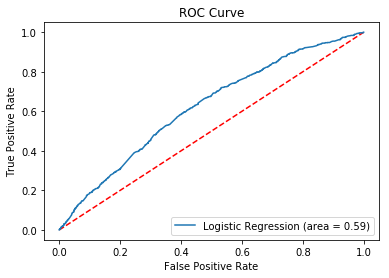

In [31]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

logit_roc_auc = roc_auc_score(y_res_test, lr.predict(X_res_test))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = lr.predict_proba(X_res_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_res_test, y_pred_prob)

# Plot ROC curve
fig, ax = plt.subplots()
_ = ax.plot([0, 1], [0, 1], 'r--')
_ = ax.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
_ = ax.set_xlabel('False Positive Rate')
_ = ax.set_ylabel('True Positive Rate')
_ = ax.set_title('ROC Curve')
_ = ax.legend(loc="lower right")
plt.show()

fig.savefig('plots/lr_roc_curve.png')



### Voting Classifier and Model Comparison

I next used an ensemble Voting Classifier model that contained a logistic regression classifer, a Random Forest classifier and a K-Nearest Neighbors classifer.  After training the ensemble on the training set, I obtained an accuracy score of approximately 98.5%.  Running a loop over each component model in addition to the Voting Classifier, I obtained the following accuracy scores for the test data to the nearest tenth of a percent:  Logistic Regression at 58.9% (not using feature reduction or hyperparameter selection here), Random Forest at 61.0%, K-Nearest Neighbors at 75.8% and the Voting Classifier at 70.7%.  

I attempted to improve the results from the Random Forest and Voting Classifier and in both cases still got inferior results compared to K-Neighbors.  

For Random forest, I increased the number of trees to 300.  The improvement to the accuracy score was about .5 percent.  I ran small loop from 10, the default value, to 30 similar to what I did for knn to get an optimum number of estimators, just to see if there was any improvement as the number of estimators was increased and there was virtually none, as shown in the bottom cell.  

I then attempted to use 300 estimators directly in the Voting Classifier.  The accuracy score was 0.6162, only a slight improvement, and appears to be supported by the plot below.  

I also attempted to adjust the weights for the Voting Classifier to get an improved score.  I adjusted the weights to [.1, .2, .7], where .1 was for the logistic regression, .2 was for the Random Forest and .7 was for KNeighbors.  The Voting Classifier had an improved score of .7575, just slightly less than the KNeighbors classifier at .7577.  

I also looked at the Precision, Recall and F1 scores for both methods.  For the Random Forest (with n_estimators=300), the Precision for the positive class was a very high .98, but the Recall was only a .24.  The F1 score for the positive class was only a .38, so this simply does not appear to be a good model for this dataset.  For the Voting Classifier, the Precision for the positive class was a .85, but only a .63 for the Recall and a .72 for the F1 score.  The F1 score here on the positive class, while decent, is still .01 less than the F1 score for the positive class using KNeighbors.  Random Forest and Voting Classifier appear to be making few Type I errors, but a large number of Type II errors. 

Since the K-Nearest Neighbors model performed the best, I ultimately chose to use this model for the present dataset.  

In [32]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import VotingClassifier 
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier

log_clf = LogisticRegression() 
rnd_clf = RandomForestClassifier(n_estimators=300, random_state=42) 
knn_clf = KNeighborsClassifier(n_neighbors=4)

voting_clf = VotingClassifier(
    estimators =[('lr', log_clf), ('rf', rnd_clf), ('knn', knn_clf)], weights = [.1, .2, .7], voting ='soft') 



In [33]:
#Reset X_res_train and y_res_train to previous number of features
X = traffic_clean_ml.drop(['SERIOUS_FATALS'], axis=1)
y = traffic_clean_ml['SERIOUS_FATALS']



In [34]:
#Split data into train and test sets with test size at 20%
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=42, stratify=y)

#Oversample train and test sets
ros_train = RandomOverSampler(random_state=42)
X_res_train, y_res_train = ros_train.fit_sample(X_train, y_train)

ros_test = RandomOverSampler(random_state=42)
X_res_test, y_res_test = ros_test.fit_sample(X_test, y_test)



In [35]:
#Train Voting Classifier

voting_clf.fit(X_res_train, y_res_train)

print("Training score: {:.4f}".format(voting_clf.score(X_res_train, y_res_train)))

Training score: 0.9746


In [36]:
from sklearn.metrics import accuracy_score

print("Testing score: \n")

for clf in (log_clf, rnd_clf, knn_clf, voting_clf):
    clf.fit(X_res_train, y_res_train)
    y_pred = clf.predict(X_res_test)
    print(clf.__class__.__name__, ": {:.4f}".format(accuracy_score(y_res_test, y_pred)))



Testing score: 

LogisticRegression : 0.5893
RandomForestClassifier : 0.6162
KNeighborsClassifier : 0.7577
VotingClassifier : 0.7575


In [37]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

y_pred1 = rnd_clf.predict(X_res_test)
y_pred2 = voting_clf.predict(X_res_test)
print("Accuracy score: {:.4f}".format(accuracy_score(y_res_test, y_pred1)))
print(confusion_matrix(y_res_test, y_pred1))
print(classification_report(y_res_test, y_pred1))

print("Accuracy score: {:.4f}".format(accuracy_score(y_res_test, y_pred2)))
print(confusion_matrix(y_res_test, y_pred2))
print(classification_report(y_res_test, y_pred2))



Accuracy score: 0.6162
[[9446   37]
 [7242 2241]]
             precision    recall  f1-score   support

          0       0.57      1.00      0.72      9483
          1       0.98      0.24      0.38      9483

avg / total       0.77      0.62      0.55     18966

Accuracy score: 0.7575
[[8402 1081]
 [3519 5964]]
             precision    recall  f1-score   support

          0       0.70      0.89      0.79      9483
          1       0.85      0.63      0.72      9483

avg / total       0.78      0.76      0.75     18966



In [38]:
#Reset X to original values and re-process
#Reset X_res_train and y_res_train to previous number of features
X = traffic_clean_ml.drop(['SERIOUS_FATALS'], axis=1)
y = traffic_clean_ml['SERIOUS_FATALS']


In [39]:
#Split data into train and test sets with test size at 20%
X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size = 0.2, random_state=42, stratify=y)

#Oversample train and test sets
ros_train = RandomOverSampler(random_state=42)
X_res_train, y_res_train = ros_train.fit_sample(X_train, y_train)

ros_test = RandomOverSampler(random_state=42)
X_res_test, y_res_test = ros_test.fit_sample(X_test, y_test)



### K-Nearest Neighbors Classifier

In order to obtain the optimal k to use for the K-Nearest Neighbors classifier, I looped over several possible k-values from 1 through 8 and plotted the accuracy scores for both the training set and test set in a single plot.  This plot may be viewed in the bottom cell.  (Please note that it takes a substantial amount of time to run, i.e., approximately 20 minutes, and for this reason has been set off from the other cells in this notebook.)  

Although k=3 and k=4 gave the highest accuracy scores, there was still a substantial amount of overfitting here.  K-Neighbors overfits more at k=4 by 21.7 percentage points vs. k=7 with 17.4 percentage points overfitting.  The drop in test accuracy is a little under 2 percent going from k=4 (75.8%) to k=7 at 74.2%, so the small drop in accuracy of 1.6% appears to be  worth the 4.3% drop in overfitting. I also attempted to use a weighting function for the nearest neighbors such that weights would be inversely proportional to distance using the weights='distance' parameter.  However, this also resulted in overfitting, and the improvements it provided were again minimal, as illustrated further in the second to last plot below. Accordingly, I ultimately adopted k=7 as the k-value for this model with the weights equal to 1. 

At k=7, the training accuracy score for the K-Nearest Neighbors classifier was 91.6%, while the testing accuracy score was, as stated, 74.2%. The Precision for the positive class (1) was .76, while the Recall (or Sensitivity) was .71.  Therefore, in 76% of cases the model correctly identified a serious fatality out of each time it predicted a serious fatality. In 71% of instances it correctly identified a serious fatality out of all possible serious fatalities in the dataset.  Finally, the F1 score for the positive class was .73. All of these scores thus indicated a substantial improvement over the previous logistic regression model. The confusion matrix and classification report displaying the foregoing results are printed below.

In [40]:
from sklearn.neighbors import KNeighborsClassifier

knn_clf = KNeighborsClassifier(n_neighbors=7)

knn_clf.fit(X_res_train, y_res_train)

print("Training score: {:.4f}".format(knn_clf.score(X_res_train, y_res_train)))


Training score: 0.9162


In [41]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

y_pred = knn_clf.predict(X_res_test)
print("Accuracy score: {:.4f}".format(accuracy_score(y_res_test, y_pred)))
print(confusion_matrix(y_res_test, y_pred))
print(classification_report(y_res_test, y_pred))


Accuracy score: 0.7420
[[7336 2147]
 [2746 6737]]
             precision    recall  f1-score   support

          0       0.73      0.77      0.75      9483
          1       0.76      0.71      0.73      9483

avg / total       0.74      0.74      0.74     18966



I then plotted the ROC Curve for the present model. The results for the K-Nearest Neighbors model are shown below, showing an area under the curve (AUC) of .74 and a curve that is substantially above the 45 degree reference line, thus indicating a model that performs much better than chance.  

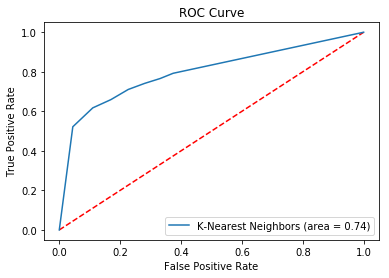

In [42]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

knn_roc_auc = roc_auc_score(y_res_test, knn_clf.predict(X_res_test))

# Compute predicted probabilities: y_pred_prob
y_pred_prob = knn_clf.predict_proba(X_res_test)[:,1]

# Generate ROC curve values: fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_res_test, y_pred_prob)

# Plot ROC curve
fig, ax = plt.subplots()
_ = ax.plot([0, 1], [0, 1], 'r--')
_ = ax.plot(fpr, tpr, label='K-Nearest Neighbors (area = %0.2f)' % knn_roc_auc)
_ = ax.set_xlabel('False Positive Rate')
_ = ax.set_ylabel('True Positive Rate')
_ = ax.set_title('ROC Curve')
_ = ax.legend(loc="lower right")
plt.show()

fig.savefig('plots/knn_roc_curve.png')



## Analysis and Conclusion

Despite the improved scores obtained through the K-Nearest Neighbors model on the test data, there was still overfitting unlike with the logistic regression model where feature reduction algorithms were employed.  

The use of PCA and other feature-reducing tools was attempted with the K-Nearest Neighbors model, but ultimately had no beneficial impact since the nature of the data was such that each feature had to be split into many sub-features first that then needed to be binarized before being able to submit the data to a machine learning algorithm. Removing subfeatures using a feature reducer resulted in some subfeatures of a given feature being lost, but not all.  This resulted in substantially reduced accuracy when using feature reducers. Nevertheless, I was able to remove some features by hand at the outset before binarizing the variables where I observed redundancy between features. 

Despite attempting to use an ensemble Voting Classifier method consisting of Logistic Regression, a Random Forest and K-Nearest Neighbors, it failed to outperform K-Nearest Neighbors, as did the Random Forest by itself. Perhaps the Voting Classifier was not performing better than its components because these methods all have similar strengths and weaknesses (at least with respect to the present dataset), so we don’t have a situation where the strengths of one component make up for the weaknesses in another.  Instead there was just an averaging of results, such that the Voting Classifier would never perform better than its strongest component. The issue is likely related to the dataset itself and the way that the variables had to be subdivided into binaries, thus making it too rigid. K-Neighbors likely worked better here because, as noted by the Sci-Kit Learn User Guide, "it does not attempt to construct a general internal model, but simply stores instances of the training data" and "...is often successful in classification situations where the decision boundary is very irregular", as is likely the situation here. Based on the foregoing, the K-Nearest Neighbors method appears to be superior with respect to the present dataset.  

As discussed above, I was ultimately able to reduce the extent of overfitting by selecting a higher k-value at k=7, rather than at k=4, and this appeared to provide the best trade-off between reducing overfitting and maximizing accuracy.  In addition to an improved accuracy score, the model also provided improved Precision, Recall and F1 scores and a much greater area under the curve in the model's ROC plot. Therefore, this model appears to have maximized its predictive power and successfully predicted the occurrence of serious fatalities at a high rate with the given data.  

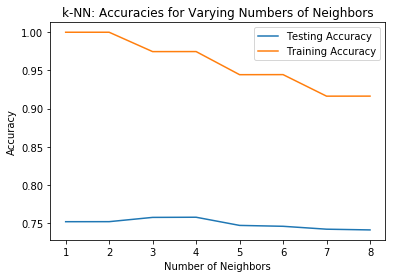

In [3]:
##REFERENCE ONLY--ESTABLISHES OPTIMUM K--DO NOT RUN AGAIN--20 MINUTE RUNTIME
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#Neighbors variable for looping over k-values and arrays for train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k using KNeighborsClassifier
for i, k in enumerate(neighbors):
    
    knn = KNeighborsClassifier(n_neighbors=k)

    knn.fit(X_res_train, y_res_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_res_train, y_res_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_res_test, y_res_test)

# Plot accuracies for train and test sets for all values of k
fig, ax = plt.subplots()

_ = ax.set_title('k-NN: Accuracies for Varying Numbers of Neighbors')
_ = ax.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
_ = ax.plot(neighbors, train_accuracy, label = 'Training Accuracy')
_ = ax.legend()
_ = ax.set_xlabel('Number of Neighbors')
_ = ax.set_ylabel('Accuracy')
plt.show()

fig.savefig('plots/knn_k-values.png')

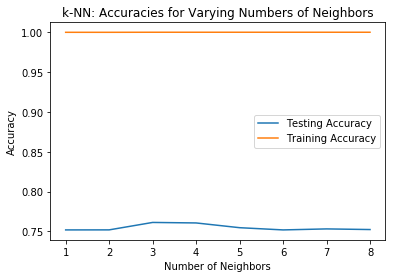

In [48]:
##REFERENCE ONLY--ESTABLISHES OPTIMUM K--DO NOT RUN AGAIN--20 MINUTE RUNTIME
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#Neighbors variable for looping over k-values and arrays for train and test accuracies
neighbors = np.arange(1, 9)
train_accuracy = np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))

# Loop over different values of k using KNeighborsClassifier
for i, k in enumerate(neighbors):
    
    knn = KNeighborsClassifier(n_neighbors=k, weights='distance')

    knn.fit(X_res_train, y_res_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = knn.score(X_res_train, y_res_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = knn.score(X_res_test, y_res_test)

# Plot accuracies for train and test sets for all values of k
fig, ax = plt.subplots()

_ = ax.set_title('k-NN: Accuracies for Varying Numbers of Neighbors')
_ = ax.plot(neighbors, test_accuracy, label = 'Testing Accuracy')
_ = ax.plot(neighbors, train_accuracy, label = 'Training Accuracy')
_ = ax.legend()
_ = ax.set_xlabel('Number of Neighbors')
_ = ax.set_ylabel('Accuracy')
plt.show()

fig.savefig('plots/knn_k-values_weights.png')

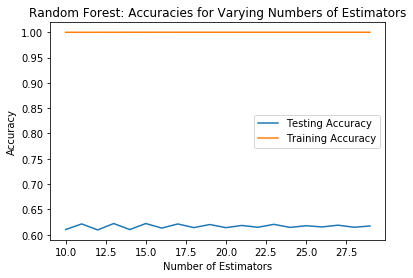

In [3]:
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

#Estimators variable for looping over number of estimators and arrays for train and test accuracies
estimators = np.arange(10, 30)
train_accuracy = np.empty(len(estimators))
test_accuracy = np.empty(len(estimators))

# Loop over different values of k using RandomForestClassifer
for i, k in enumerate(estimators):
    
    rnd_clf = RandomForestClassifier(n_estimators=k, random_state=42) 
    
    rnd_clf.fit(X_res_train, y_res_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = rnd_clf.score(X_res_train, y_res_train)

    #Compute accuracy on the testing set
    test_accuracy[i] = rnd_clf.score(X_res_test, y_res_test)

# Plot accuracies for train and test sets for all values of k
fig, ax = plt.subplots()

_ = ax.set_title('Random Forest: Accuracies for Varying Numbers of Estimators')
_ = ax.plot(estimators, test_accuracy, label = 'Testing Accuracy')
_ = ax.plot(estimators, train_accuracy, label = 'Training Accuracy')
_ = ax.legend()
_ = ax.set_xlabel('Number of Estimators')
_ = ax.set_ylabel('Accuracy')
plt.show()

fig.savefig('plots/RF_Estimators.png')